In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network
from src.utils.general_old import get_cond_matrix

from network_parameters import network_parameters

In [3]:
recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = 100



input_params = {}
input_params["num_days"] = 1000
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [4]:
network = SSCNetwork(network_parameters, recording_parameters)
rf_0 = network.ctx_mtl.clone()
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [5]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


network.selectivity_ctx, network.ordered_indices_ctx  = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)

In [6]:
torch.save(network, "checkpoints/network_2.pt")
network = torch.load("checkpoints/network_2.pt", weights_only=False)

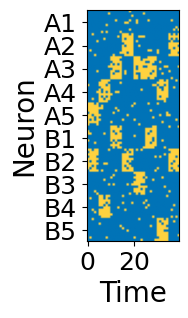

In [7]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/2b1.svg', dpi=300, transparent=True)

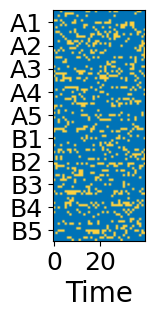

In [8]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100][:, network.ordered_indices_ctx[:100]].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1) 

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
#plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/2b2.svg', dpi=300, transparent=True)

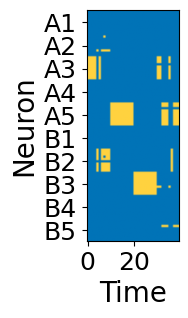

In [9]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/2c1.svg', dpi=300, transparent=True)

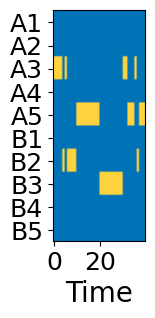

In [10]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][:input_params["day_length"]//2, :100][:, network.ordered_indices_ctx[:100]].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)
plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)


plt.savefig('Figures_SVG/2c2.svg', dpi=300, transparent=True)

In [11]:
rf_ctx_mtl = torch.stack(network.connectivity_recordings["ctx_mtl"], dim=0)[:, network.ordered_indices_ctx]

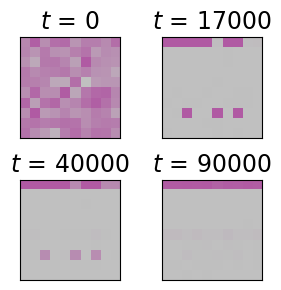

In [61]:
neuron = 1
fig, axs = plt.subplots(2, 2, figsize=(3, 3))  # 1 row, 3 columns



vmin_0 = torch.min(rf_ctx_mtl[1, neuron, :100])
vmax_0 = torch.max(rf_ctx_mtl[1, neuron, :100])


vmin= torch.min(rf_ctx_mtl[0, neuron, :100])
vmax= torch.max(rf_ctx_mtl[0, neuron, :100])

axs[0, 0].imshow(rf_ctx_mtl[1, neuron, :100].reshape(-1, 10), cmap=gray_purple, vmin=vmin_0, vmax=vmax_0)
axs[0, 0].set_title(r'$t$ = 0', fontsize=17)

axs[0, 1].imshow(rf_ctx_mtl[170, neuron, :100].reshape(-1, 10), cmap=gray_purple, vmin=vmin, vmax=vmax)
axs[0, 1].set_title(r'$t$ = 17000', fontsize=17)

axs[1, 0].imshow(rf_ctx_mtl[300, neuron, :100].reshape(-1, 10), cmap=gray_purple, vmin=vmin, vmax=vmax)
axs[1, 0].set_title(r'$t$ = 40000', fontsize=17)

axs[1, 1].imshow(rf_ctx_mtl[900, neuron, :100].reshape(-1, 10), cmap=gray_purple, vmin=vmin, vmax=vmax)
axs[1, 1].set_title(r'$t$ = 90000', fontsize=17)

for i, axs in enumerate(axs.flat):
    axs.set_xticks([])
    axs.set_yticks([])
plt.tight_layout()
plt.savefig('Figures_SVG/2d1.svg', dpi=300, transparent=True)

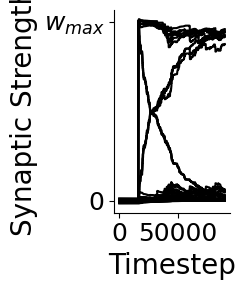

In [65]:
fig = plt.figure(figsize=(2.5, 3))
# Example plots
for w in rf_ctx_mtl[1:, neuron, :100].transpose(0, 1):
    plt.plot(w, color='black')
plt.xlabel("Timestep", fontsize=20)
plt.ylabel("Synaptic Strength", fontsize=20)
plt.xticks([0, 500], [0, 50000], fontsize=18)
plt.yticks([0, 0.1], [0, r"$w_{max}$"], fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('Figures_SVG/2d2.svg', dpi=300, transparent=True)

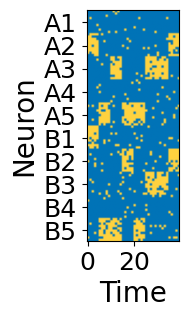

In [66]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.awake_indices][-input_params["day_length"]//2:, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)
plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Neuron", fontsize=20)
plt.savefig('Figures_SVG/2e1.svg', dpi=300, transparent=True)

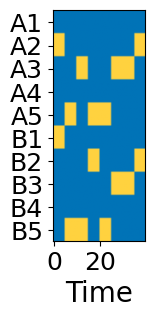

In [67]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-input_params["day_length"]//2:, :100][:, network.ordered_indices_ctx[:100]].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

plt.yticks([])
plt.xticks([0, 20], fontsize=18)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/2e2.svg', dpi=300, transparent=True)

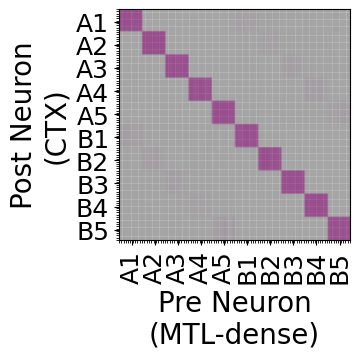

In [68]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(network.ctx_mtl[network.ordered_indices_ctx][:100][:, :100], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions, labels,  fontsize=18, rotation=90)
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron\n(CTX)", fontsize=20)
plt.xlabel("Pre Neuron\n(MTL-dense)", fontsize=20)
plt.savefig('Figures_SVG/2f.svg', dpi=300, transparent=True)

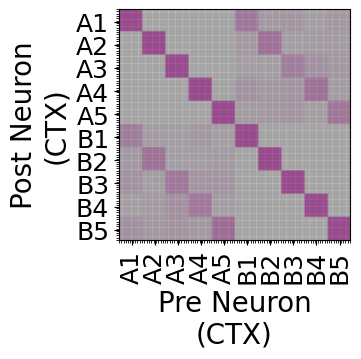

In [69]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(network.ctx_ctx[network.ordered_indices_ctx][:, network.ordered_indices_ctx][:100][:, :100], cmap=gray_purple)

plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions, labels,  fontsize=18, rotation=90)
plt.yticks(positions, labels, fontsize=18)
plt.ylabel("Post Neuron\n(CTX)", fontsize=20)
plt.xlabel("Pre Neuron\n(CTX)", fontsize=20)
plt.savefig('Figures_SVG/2g1.svg', dpi=300, transparent=True)

In [70]:
sim_cond_matrix, th_cond_matrix = get_cond_matrix(input_params["latent_space"], np.array(network.mtl_dense_mtl_dense), 1)
th_cond_matrix = np.repeat(np.repeat(th_cond_matrix, 10, axis=0), 10, axis=1).flatten()

/tmp/ipykernel_3513652/1690407667.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  sim_cond_matrix, th_cond_matrix = get_cond_matrix(input_params["latent_space"], np.array(network.mtl_dense_mtl_dense), 1)


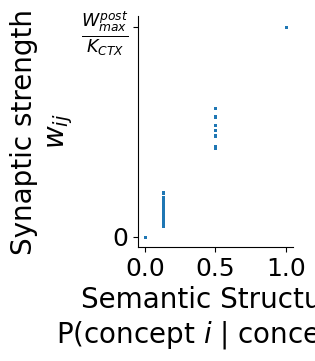

In [72]:
fig = plt.figure(figsize=(2, 3))


plt.scatter(th_cond_matrix, network.ctx_ctx[network.ordered_indices_ctx][:, network.ordered_indices_ctx][:100][:, :100].flatten(), s=0.5)


sns.despine()
plt.xlabel("Semantic Structure\nP(concept $i$ | concept $j$)", fontsize=20)
plt.ylabel("Synaptic strength\n$w_{ij}$", fontsize=20)
plt.yticks([0, 0.05], ["0",r"$\frac{W_{max}^{post}}{K_{CTX}}$"], fontsize=18)
plt.xticks([0, 0.5, 1], fontsize=18)


plt.savefig('Figures_SVG/2g2.svg', dpi=300, transparent=True)